In [1]:
 #from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply
from tensorflow.keras import backend as K
import cv2, numpy as np
import glob
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu 
import keras as keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,add,Reshape

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses
from tensorflow.keras.layers import  Layer,Activation, Lambda, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf
from tensorflow.keras.losses import mse, binary_crossentropy


from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from tensorflow.keras import backend as K
from pathlib import Path
from keras import objectives

from tensorflow.keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa
from tensorflow.keras.datasets import  mnist, fashion_mnist

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


from datetime import datetime
from scipy.fftpack import dct, idct
import copy

Using TensorFlow backend.


In [2]:


# load MNIST dataset
(x_train, y_train), (X_test, Y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
Y_test = to_categorical(Y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
X_test = np.reshape(X_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

x_val=X_test[:8000]
y_val=Y_test[:8000]

x_test=X_test[8000:]
y_test=Y_test[8000:]
 

In [3]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 64
dropout = 0.3

In [4]:

 
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(y)
 
y = Flatten()(y)
 
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

 
model = Model(inputs=inputs, outputs=outputs)
 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

In [5]:
permt = [1,2,3]
subbands = ["d", "h", "v"]
img_size=28
n_channels=1




def applyDCTPermutation(data, permutation,n_channels,img_size):

    n = data.shape[0]

    for i in range(n):
        for c in range(n_channels):
            xdct = dct(dct(data[i, :, :, c]).T)
            xdct = applySignPermutation(xdct, permutation,img_size)
            data[i, :, :, c] = idct(idct(xdct).T)
            nrm = np.sqrt(np.sum(data[i, :, :, c]**2))
            data[i, :, :, c] /= nrm

    return data


def applySignPermutation(data, permutation,img_size):
    dim = data.shape

    data = np.reshape(data, (-1, img_size ** 2))
    data = np.multiply(data, np.tile(permutation, (data.shape[0], 1)))

    return np.reshape(data, dim)


def signPermutation(is_zero, subband , img_size):
        if is_zero:
            permutation = np.zeros((1, image_size ** 2))
        else:
            permutation = np.random.normal(size= image_size ** 2)
            permutation[permutation >= 0] = 1
            permutation[permutation != 1] = -1

        if subband == "d":  # D - diagonal
            permutation = np.reshape(permutation, ( image_size,  image_size))
            permutation[0: image_size // 2, :] = 1
            permutation[:, 0: image_size // 2] = 1

        elif subband == "v":  # V - vertical
            permutation = np.reshape(permutation, ( image_size,  image_size))
            permutation[:, 0: image_size // 2] = 1
            permutation[ image_size // 2: image_size, :] = 1

        elif subband == "h":  # H - horizontal
            permutation = np.reshape(permutation, ( image_size,  image_size))
            permutation[0: image_size // 2, :] = 1
            permutation[:,  image_size // 2: image_size] = 1

        elif subband == "dhv":
            permutation = np.reshape(permutation, ( image_size, image_size))
            permutation[0: image_size // 2, 0: image_size // 2] = 1

        return np.reshape(permutation, ( image_size ** 2))








In [6]:
is_zero=False

for p in permt:
    for subband in subbands:
        filepath=str(p) +'_'+ str(subband)+".hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
 
        
        permutation =  signPermutation(is_zero,subband,img_size)
        x_train = applyDCTPermutation(x_train, permutation,n_channels,img_size)
        x_test = applyDCTPermutation(x_test, permutation,n_channels,img_size)
        model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
        model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=4,batch_size=batch_size, callbacks = [checkpoint])
     
        

Train on 60000 samples, validate on 2000 samples
Epoch 1/4
59264/60000 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.8632
Epoch 00001: val_loss improved from inf to 0.05885, saving model to 1_d.hdf5
60000/60000 [==============================] - 4s 70us/sample - loss: 0.4314 - accuracy: 0.8643 - val_loss: 0.0589 - val_accuracy: 0.9835
Epoch 2/4
59136/60000 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9659
Epoch 00002: val_loss improved from 0.05885 to 0.03465, saving model to 1_d.hdf5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1102 - accuracy: 0.9660 - val_loss: 0.0347 - val_accuracy: 0.9890
Epoch 3/4
59008/60000 [============================>.] - ETA: 0s - loss: 0.0773 - accuracy: 0.9762
Epoch 00003: val_loss improved from 0.03465 to 0.02470, saving model to 1_d.hdf5
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.0247 - val_accuracy: 0.9915
E

Epoch 3/4
58880/60000 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9959
Epoch 00003: val_loss did not improve from 0.01178
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.0146 - val_accuracy: 0.9970
Epoch 4/4
59520/60000 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9956
Epoch 00004: val_loss did not improve from 0.01178
60000/60000 [==============================] - 3s 44us/sample - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.0126 - val_accuracy: 0.9960
Train on 60000 samples, validate on 2000 samples
Epoch 1/4
59904/60000 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9956
Epoch 00001: val_loss improved from inf to 0.01366, saving model to 3_h.hdf5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0123 - accuracy: 0.9956 - val_loss: 0.0137 - val_accuracy: 0.9960
Epoch 2/4
58752/60000 [============================>.] - ETA:

## Test Phase
 

In [15]:
 
def impr(im):
    ar=[]
    img = np.asarray(im) 
    ar.append(img) 
    ay = np.asarray(ar)
    return ay

In [57]:
i=3449
# original_label

y_val[i].argmax(0)

3

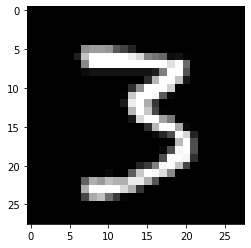

In [58]:
# original test image

plt.imshow(x_val[i],cmap='gray')


In [61]:
ml=[]
for p in permt:
    for subband in subbands:
        model.load_weights(str(p) +'_'+ str(subband)+".hdf5")
        img=x_val[i]
        im=impr(img)
        permutation =  signPermutation(is_zero,subband,img_size)
        im = applyDCTPermutation(im, permutation,n_channels,img_size)
        pr=model.predict(im)
        ml.append(pr)








In [62]:
# prediction for all permutation_/_subbands 

mr=np.asarray(ml)
mr.argmax(2)

array([[3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3]], dtype=int64)